In [1]:
from qutip import *
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO

from qutip.control import * 
from qutip.ui.progressbar import TextProgressBar
from qutip.control.grape import plot_grape_control_fields, _overlap


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import h5py

In [2]:
U_targetsFile = h5py.File("U_targets.hdf5", 'r')
#Find a way to do this using rel path to the Results folder 
#rather than copy paste the file to this directory
#Not import rn but do later

U_targets = np.array(U_targetsFile["U_targets"])

sample = 10

U_target_arr = []

U_final_pulseoptim = []
U_final_cyGRAPE = []

# U_test = np.zeros((3,3,sample), dtype='complex') 


for i in range(sample):
    U_target_arr.append(Qobj(U_targets[:,:,i])) #not a good method for memory 
    
    # U_test[:,:,i] = Qobj(U_targets[:,:,i]) #better way but is unfortunatley casting to a complex value instead of a Qobj (dtype = 'object' didnt work either)

# display(U_test[:,:,0])
display(U_target_arr[0])





C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[ 0.97386906+0.00220554j  0.02694935+0.22244521j -0.03589719+0.00879961j]
 [ 0.02969902+0.22209468j  0.89159271-0.23321263j  0.11587788+0.29502293j]
 [-0.03567618+0.00965991j  0.11931038+0.29365146j  0.82969733-0.45800663j]]

In [3]:
H_drift_matrix = np.array([[0,0,0],
                           [0,0.515916, 0],
                           [0,0,1]])
H_control_matrix = np.array([[0,1/np.sqrt(2), 0],
                             [1/np.sqrt(2),0,0],
                             [0, 1, 0]])

H_drift = Qobj(H_drift_matrix)
H_control = [Qobj(H_control_matrix)] 
 
# Unitary starting point
U_0 = qeye(3)



C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# pulseoptim

In [4]:
#pulse optim extra params (arbitary values)

# Number of time slots
n_ts = 3
# Time allowed for the evolution
evo_time = 1


# Fidelity error target
fid_err_targ = 1e-10
# Maximum iterations for the optisation algorithm
max_iter = 200
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'RND' 


C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
for i in range(sample):
    result = cpo.optimize_pulse_unitary(H_drift, H_control, U_0, U_target_arr[i], n_ts, evo_time, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                log_level=log_level,
                init_pulse_type=p_type, 
                gen_stats=True)
    print("Final fidelity error {}".format(result.fid_err))
    #print("Final fidelity {}".format(result.fidelity)) #?? this always gives 0.0 even though the fid_err is never 1.0
    # print("Final gradient normal {}".format(result.grad_norm_final))
    print("Terminated due to {}".format(result.termination_reason))
   
    #Here all terminate due to convergence however if it terminates due to a different reason may cause a problem
    U_final_pulseoptim.append(result.evo_full_final)
    print(i)
    

#display(U_final_pulseoptim)


C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.    

Final fidelity error 0.002546705931824711
Terminated due to function converged
0
Final fidelity error 0.0026980375377398946
Terminated due to function converged
1


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0025807704527254227
Terminated due to function converged
2
Final fidelity error 0.002812708960952426
Terminated due to function converged
3
Final fidelity error 0.002524526512805547
Terminated due to function converged
4


INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Target state / operator:
Quantu

Final fidelity error 0.002491453158376844
Terminated due to function converged
5
Final fidelity error 0.020661439918973623
Terminated due to function converged
6
Final fidelity error 0.020705497029405273
Terminated due to function converged
7


INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:


Final fidelity error 0.002690593310150091
Terminated due to function converged
8
Final fidelity error 0.0025967022236922377
Terminated due to function converged
9


In [6]:
# cy_grape params
times = np.linspace(0,evo_time,n_ts)
n_iterations = 100



C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
for i in range(sample):
    print(i)
    result = cy_grape_unitary(U_target_arr[i], H_drift, H_control, n_iterations, times, eps=2*np.pi/times[-1], phase_sensitive=False
                           ,progress_bar=TextProgressBar())
    U_final_cyGRAPE.append(result.U_f)
#display(U_final_cyGRAPE)

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
10.0%. Run time:   0.16s. Est. time left: 00:00:00:01
20.0%. Run time:   0.25s. Est. time left: 00:00:00:01
30.0%. Run time:   0.34s. Est. time left: 00:00:00:00
40.0%. Run time:   0.43s. Est. time left: 00:00:00:00
50.0%. Run time:   0.52s. Est. time left: 00:00:00:00
60.0%. Run time:   0.59s. Est. time left: 00:00:00:00
70.0%. Run time:   0.68s. Est. time left: 00:00:00:00
80.0%. Run time:   0.75s. Est. time left: 00:00:00:00
90.0%. Run time:   0.84s. Est. time left: 00:00:00:00
Total run time:   0.92s
1
10.0%. Run time:   0.07s. Est. time left: 00:00:00:00
20.0%. Run time:   0.17s. Est. time left: 00:00:00:00
30.0%. Run time:   0.25s. Est. time left: 00:00:00:00
40.0%. Run time:   0.33s. Est. time left: 00:00:00:00
50.0%. Run time:   0.48s. Est. time left: 00:00:00:00
60.0%. Run time:   0.58s. Est. time left: 00:00:00:00
70.0%. Run time:   0.66s. Est. time left: 00:00:00:00
80.0%. Run time:   0.74s. Est. time left: 00:00:00:00
90.0%. Run time:   0.84s. Est. time left: 00:00:00:00


# Comparing fidelity 

In [8]:
pulseoptim_fidelity = []
cy_grape_fidelity = []


for i in range(sample):
    print(i)
    pulseoptim_fidelity.append(abs(_overlap(U_target_arr[i], U_final_pulseoptim[i])))
    cy_grape_fidelity.append(abs(_overlap(U_target_arr[i], U_final_cyGRAPE[i])))
    
display(pulseoptim_fidelity)
display(cy_grape_fidelity)

0
1
2
3
4
5
6
7
8
9


C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.9974532859992339,
 0.9973019520043207,
 0.9974192275604902,
 0.9971872792905424,
 0.9974754716213682,
 0.9975085395862479,
 0.9793385434592129,
 0.9792944985269274,
 0.9973093971650483,
 0.9974032920421656]

[0.9668877292817418,
 0.9617913617892434,
 0.9738425030356433,
 0.9646178726895175,
 0.9750622017931687,
 0.9675904383865369,
 0.9616096659471376,
 0.9725704661057654,
 0.964486652149087,
 0.9745869422442925]

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


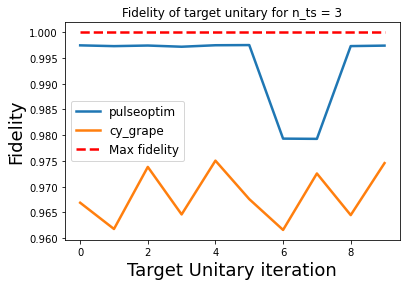

In [12]:
# Plots


sample_arr = np.arange(0,sample)
plt.title("Fidelity of target unitary for n_ts = {}".format(n_ts))
plt.xlabel('Target Unitary iteration', fontsize=18)
plt.ylabel('Fidelity', fontsize=18)
plt.plot(sample_arr, pulseoptim_fidelity, label='pulseoptim', linewidth = 2.5)
plt.plot(sample_arr, cy_grape_fidelity, label='cy_grape', linewidth = 2.5)
plt.plot(sample_arr, np.ones(10), 'r--', label ='Max fidelity' ,linewidth = 2.5)
plt.legend(fontsize=12)
plt.show()


# Conclusion

## (For 10 time slots) (rewrite for n_ts =3)

The method from the pulseoptim module appears to be more suitable option as the value of the fidelity is always below the maxium possible value, and does not vary as much as the fidelity calculated from the cy_grape_unitary method. Furthermore, the runtime for the cy_grape module is significantly larger ( ~ 3 - 5  seconds per unitary) then for the pulseoptim method (~ 0.1 second per unitary).

Note: running for a larger smaple size, the pulseoptim method terminated the calculation due to 'ABNORMAL_TERMINATION_IN_LNSRCH' instead of 'function convergence'. (https://stackoverflow.com/questions/34663539/scipy-optimize-fmin-l-bfgs-b-returns-abnormal-termination-in-lnsrch/39155976#39155976). 

